<a href="https://colab.research.google.com/github/Mahfila/test-colab/blob/main/shap_5ht1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 14.0 MB/s eta 0:00:00


In [2]:
! pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 17.9 MB/s eta 0:00:00


In [15]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Crippen, rdMolDescriptors

# Load your dataset
data = pd.read_csv('/content/5ht1b_400k.csv')

# Extract SMILES and docking scores
smiles = data['smile']
y = data['docking_score']

# Ensure all SMILES are strings
smiles = smiles.astype(str)  # Convert the 'smiles' series to string type

# Function to convert SMILES to molecular descriptors
def smiles_to_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        descriptors = {
            'mol_weight': Descriptors.MolWt(mol),
            'num_atoms': mol.GetNumAtoms(),
            'num_bonds': mol.GetNumBonds(),
            'num_rotatable_bonds': Descriptors.NumRotatableBonds(mol),
            'num_h_donors': Lipinski.NumHDonors(mol),
            'num_h_acceptors': Lipinski.NumHAcceptors(mol),
            'logp': Crippen.MolLogP(mol),
            'mr': Crippen.MolMR(mol),
            'tpsa': Descriptors.TPSA(mol),
            'num_rings': Descriptors.RingCount(mol),
            'num_aromatic_rings': Descriptors.NumAromaticRings(mol),
            'hall_kier_alpha': Descriptors.HallKierAlpha(mol),
            'fraction_csp3': rdMolDescriptors.CalcFractionCSP3(mol)
        }
        return list(descriptors.values())
    else:
        return [None] * 13  # Return a list of Nones if the SMILES string is invalid

# Apply the function to all SMILES
X = smiles.apply(smiles_to_descriptors)
X = pd.DataFrame(X.tolist(), columns=[
    'mol_weight', 'num_atoms', 'num_bonds', 'num_rotatable_bonds',
    'num_h_donors', 'num_h_acceptors', 'logp', 'mr', 'tpsa',
    'num_rings', 'num_aromatic_rings', 'hall_kier_alpha', 'fraction_csp3'])

# Drop rows with None (invalid SMILES)
X = X.dropna()
y = y[X.index]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                             max_depth = 5, alpha = 10, n_estimators = 100)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate performance metrics (e.g., RMSE)
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse:.2f}")


Root Mean Squared Error: 0.48


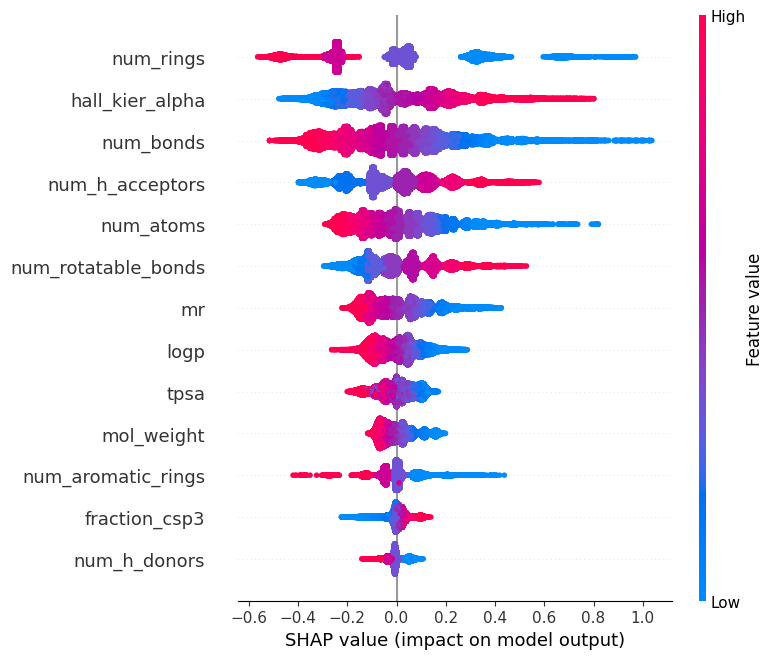

In [16]:
import shap

# Ensure your model and test data are prepared
# xgb_model, X_test from the previous sections

# Create a SHAP explainer using the trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plotting the summary plot to show the importance of each descriptor
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


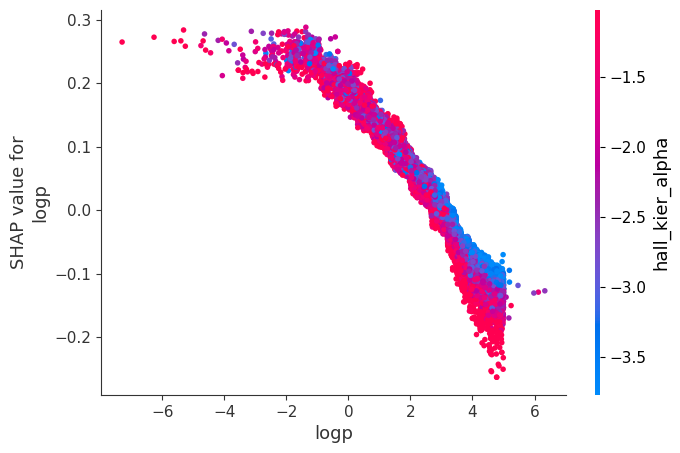

In [17]:
# 'logp' is an example, replace it with any descriptor of interest
shap.dependence_plot('logp', shap_values, X_test, feature_names=X_test.columns)


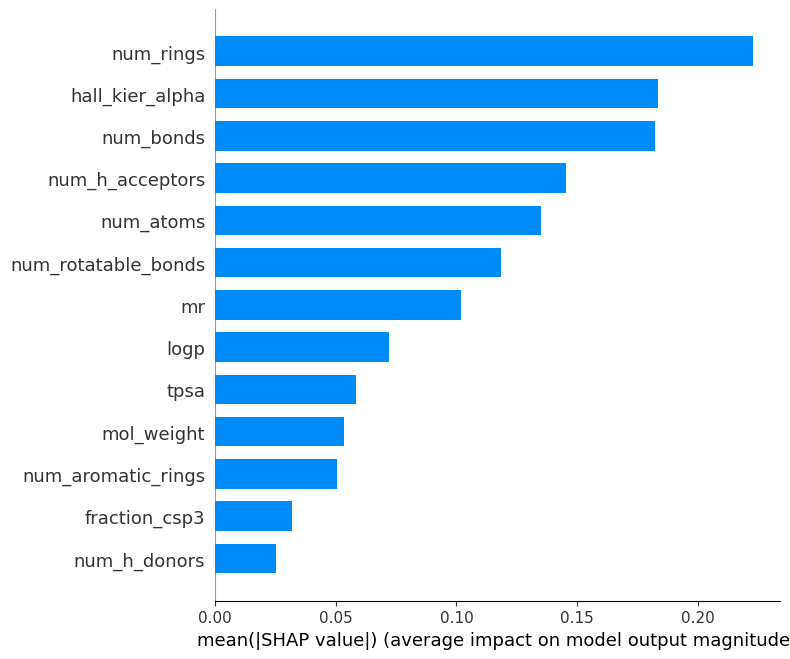

In [22]:
import shap

# Create a SHAP Tree explainer for the XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, plot_type="bar")


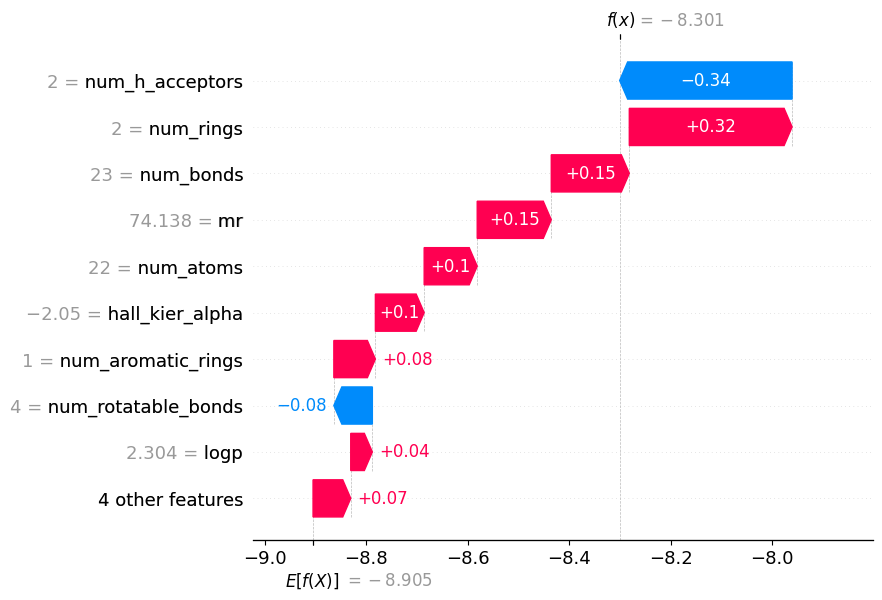

In [21]:
# Select an instance by index, here index 0 is used as an example
instance_index = 0

# Create an Explanation object for the instance
shap_explanation = shap.Explanation(
    values=shap_values[instance_index],
    base_values=explainer.expected_value,
    data=X_test.iloc[instance_index],  # Pass the instance data
    feature_names=X_test.columns.tolist()
)

# Plot the waterfall plot using the Explanation object
shap.waterfall_plot(shap_explanation)

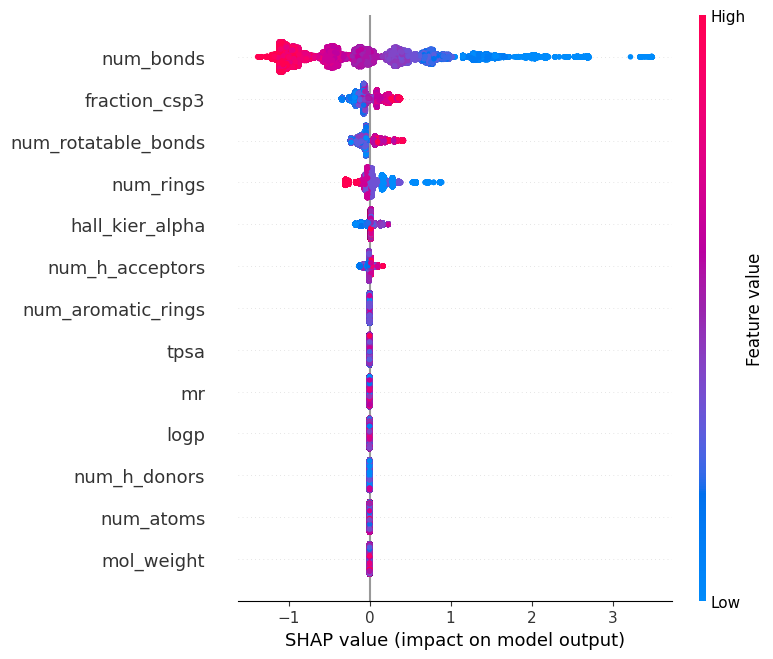

In [23]:
from sklearn.tree import DecisionTreeRegressor
import shap

# Train Decision Tree model
model_dt = DecisionTreeRegressor(max_depth=5)
model_dt.fit(X_train, y_train)

# Create SHAP explainer and calculate SHAP values
explainer_dt = shap.TreeExplainer(model_dt)
shap_values_dt = explainer_dt.shap_values(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values_dt, X_test)


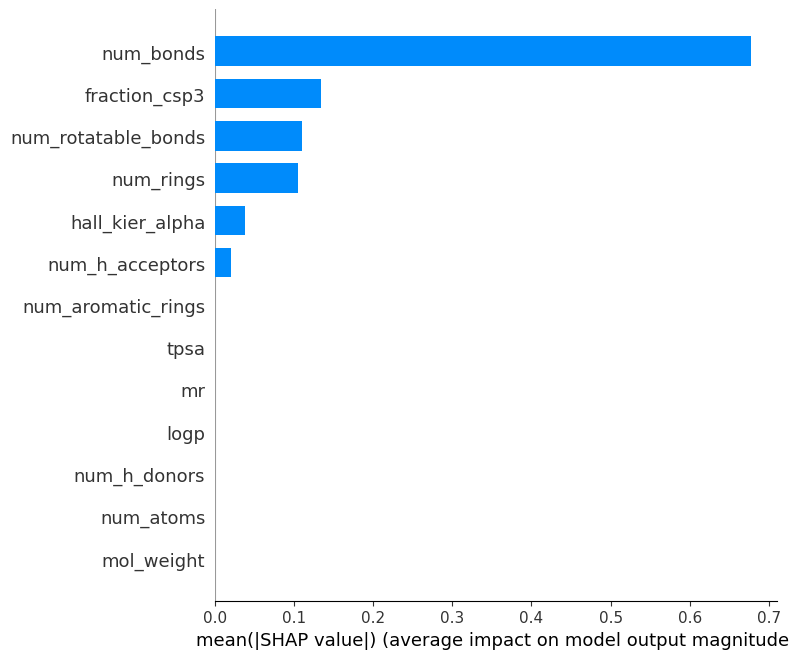

In [24]:
import shap

# Create a SHAP Tree explainer for the Decison tree model
explainer = shap.TreeExplainer(model_dt)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, plot_type="bar")


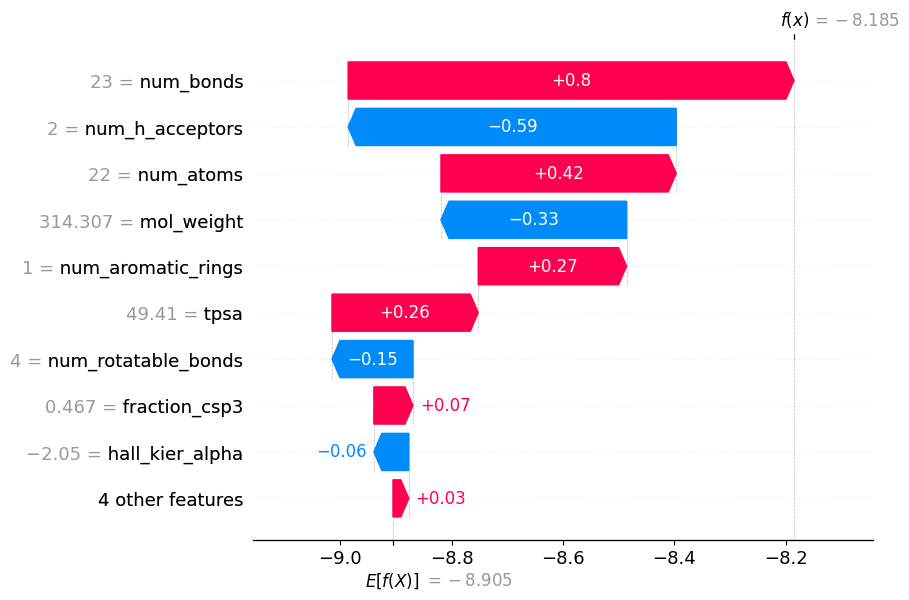

In [32]:
# Select an instance by index, here index 0 is used as an example
instance_index = 0

# Create an Explanation object for the instance
shap_explanation = shap.Explanation(
    values=shap_values[instance_index],
    base_values=explainer.expected_value,
    data=X_test.iloc[instance_index],  # Pass the instance data
    feature_names=X_test.columns.tolist()
)

# Plot the waterfall plot using the Explanation object
shap.waterfall_plot(shap_explanation)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


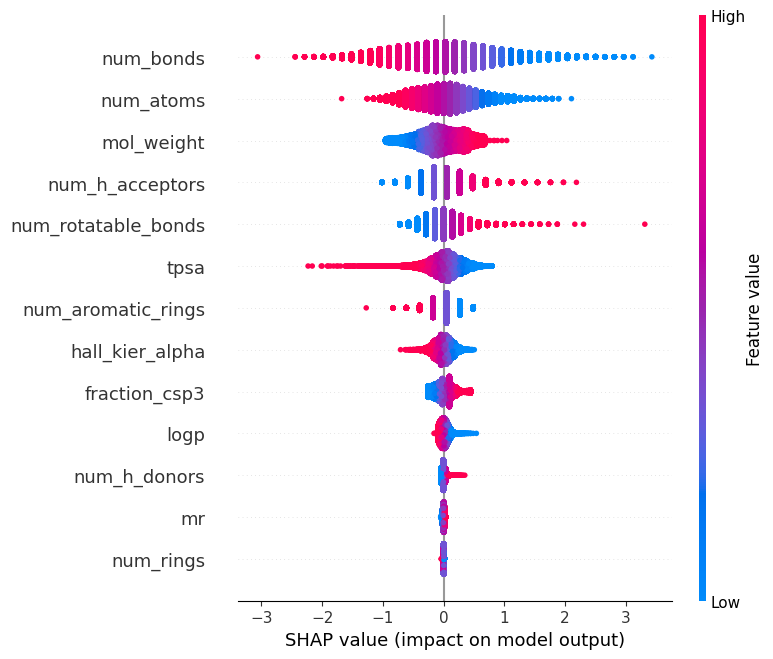

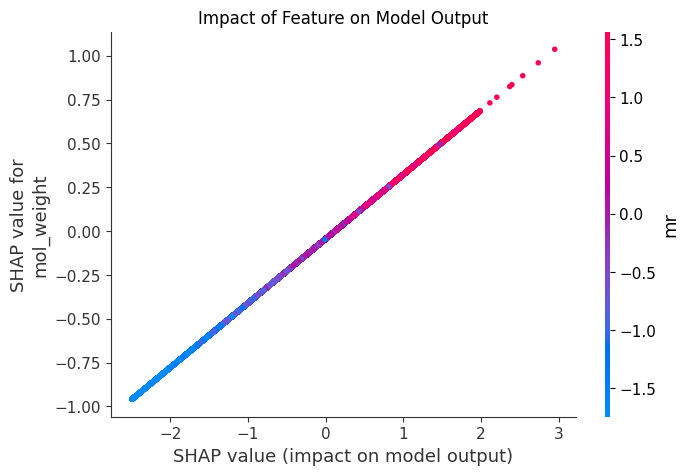

In [28]:
from sklearn.linear_model import SGDRegressor
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train SGDRegressor
model_sgd = SGDRegressor(max_iter=1000, tol=1e-3)
model_sgd.fit(X_train_scaled, y_train)
# Create SHAP explainer using LinearExplainer, use 'interventional' for feature_perturbation
explainer_sgd = shap.LinearExplainer(model_sgd, X_train_scaled, feature_perturbation="interventional")
shap_values_sgd = explainer_sgd.shap_values(X_test_scaled)

# Visualize SHAP values with summary plot
shap.summary_plot(shap_values_sgd, X_test_scaled, feature_names=X_test.columns)
# For example, visualize SHAP values for a specific feature
feature_idx = 0  # Adjust this index according to your 'docking_score' feature position
shap.dependence_plot(feature_idx, shap_values_sgd, X_test_scaled, feature_names=X_test.columns, show=False)
plt.title('Impact of Feature on Model Output')
plt.xlabel('SHAP value (impact on model output)')
plt.show()

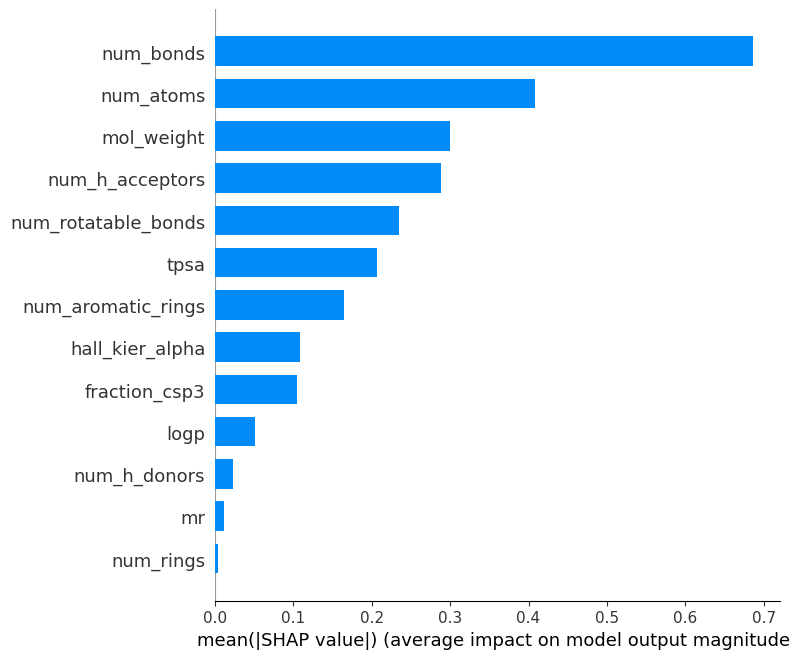

In [34]:
import shap

# Create a SHAP Linear explainer for the SGDRegressor model
explainer_sgd = shap.LinearExplainer(model_sgd, X_train_scaled)  # Assuming X_train_scaled is your background data

# Compute SHAP values for the test set
shap_values = explainer_sgd.shap_values(X_test_scaled)  # Use scaled test data

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", feature_names=X_test.columns) # Add feature names for clarity

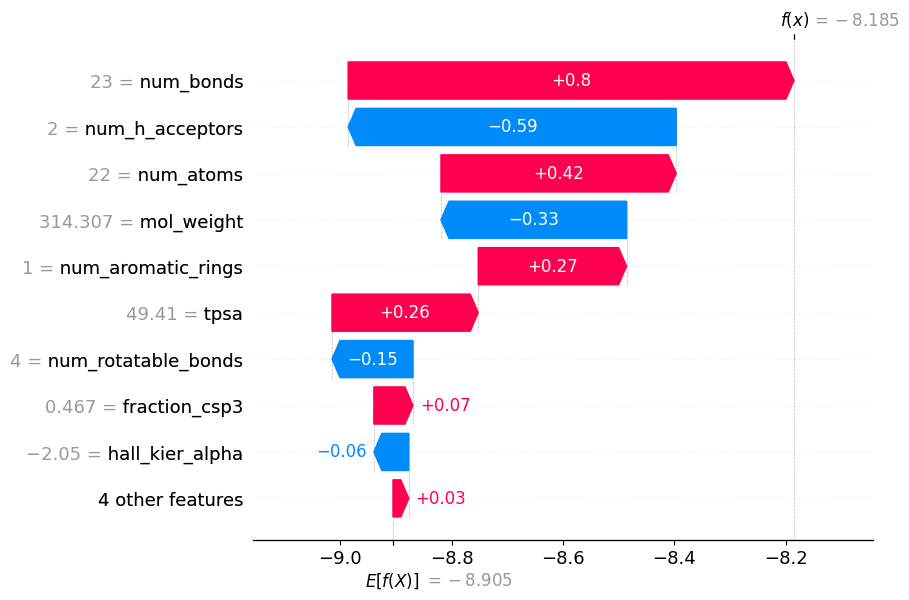

In [35]:
# Select an instance by index, here index 0 is used as an example
instance_index = 0

# Create an Explanation object for the instance
shap_explanation = shap.Explanation(
    values=shap_values[instance_index],
    base_values=explainer.expected_value,
    data=X_test.iloc[instance_index],  # Pass the instance data
    feature_names=X_test.columns.tolist()
)

# Plot the waterfall plot using the Explanation object
shap.waterfall_plot(shap_explanation)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X_train, X_test, y_train are already defined...

# Train Random Forest model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust parameters as needed
model_rf.fit(X_train, y_train)

# Create SHAP explainer and calculate SHAP values
explainer_rf = shap.TreeExplainer(model_rf)
shap_values_rf = explainer_rf.shap_values(X_test)

# Visualize SHAP values with summary plot
shap.summary_plot(shap_values_rf, X_test, feature_names=X_test.columns)

# Visualize individual predictions with force plot (for the first instance in X_test)
shap.force_plot(explainer_rf.expected_value, shap_values_rf[0,:], X_test.iloc[0,:], feature_names=X_test.columns)

# Visualize feature importance
shap.summary_plot(shap_values_rf, X_test, plot_type="bar", feature_names=X_test.columns)

In [ ]:
# For example, visualize SHAP values for a specific feature
feature_idx = 0  # Adjust this index according to your 'docking_score' feature position
shap.dependence_plot(feature_idx, shap_values_sgd, X_test_scaled, feature_names=X_test.columns, show=False)
plt.title('Impact of Feature on Model Output')
plt.xlabel('SHAP value (impact on model output)')
plt.show()

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from rdkit import Chem
from rdkit.Chem import Descriptors
import shap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Lipinski, Crippen, rdMolDescriptors



In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
import shap
import matplotlib.pyplot as plt


In [5]:
# Load your dataset
data = pd.read_csv('/content/5ht1b_400k.csv')

# Extract SMILES and docking scores
smiles = data['smile']
y = data['docking_score']

# Ensure all SMILES are strings
smiles = smiles.astype(str)  # Convert the 'smiles' series to string type

# Function to convert SMILES to molecular descriptors
def smiles_to_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        descriptors = {
            'mol_weight': Descriptors.MolWt(mol),
            'num_atoms': mol.GetNumAtoms(),
            'num_bonds': mol.GetNumBonds(),
            'num_rotatable_bonds': Descriptors.NumRotatableBonds(mol),
            'num_h_donors': Lipinski.NumHDonors(mol),
            'num_h_acceptors': Lipinski.NumHAcceptors(mol),
            'logp': Crippen.MolLogP(mol),
            'mr': Crippen.MolMR(mol),
            'tpsa': Descriptors.TPSA(mol),
            'num_rings': Descriptors.RingCount(mol),
            'num_aromatic_rings': Descriptors.NumAromaticRings(mol),
            'hall_kier_alpha': Descriptors.HallKierAlpha(mol),
            'fraction_csp3': rdMolDescriptors.CalcFractionCSP3(mol)
        }
        return list(descriptors.values())
    else:
        return [None] * 13  # Return a list of Nones if the SMILES string is invalid

# Apply the function to all SMILES
X = smiles.apply(smiles_to_descriptors)
X = pd.DataFrame(X.tolist(), columns=[
    'mol_weight', 'num_atoms', 'num_bonds', 'num_rotatable_bonds',
    'num_h_donors', 'num_h_acceptors', 'logp', 'mr', 'tpsa',
    'num_rings', 'num_aromatic_rings', 'hall_kier_alpha', 'fraction_csp3'])

# Drop rows with None (invalid SMILES)
X = X.dropna()
y = y[X.index]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error
# Convert the data to DMatrix object, which is optimized for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up parameters for XGBoost
params = {
    'max_depth': 6,  # Maximum depth of a tree
    'eta': 0.3,      # Learning rate
    'objective': 'reg:squarederror',  # Objective function
    'eval_metric': 'rmse',  # Evaluation metric for validation data
}

# Train the model
num_boost_round = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_boost_round, evals=[(dtest, 'Test')])

# Predict on test set
y_pred = model.predict(dtest)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE) on Test set: {rmse:.4f}")


[0]	Test-rmse:0.93842
[1]	Test-rmse:0.80032
[2]	Test-rmse:0.71894
[3]	Test-rmse:0.66298
[4]	Test-rmse:0.62826
[5]	Test-rmse:0.60641
[6]	Test-rmse:0.58684
[7]	Test-rmse:0.57477
[8]	Test-rmse:0.56383
[9]	Test-rmse:0.54844
[10]	Test-rmse:0.54097
[11]	Test-rmse:0.53247
[12]	Test-rmse:0.52836
[13]	Test-rmse:0.52626
[14]	Test-rmse:0.52208
[15]	Test-rmse:0.52081
[16]	Test-rmse:0.51686
[17]	Test-rmse:0.51530
[18]	Test-rmse:0.51172
[19]	Test-rmse:0.51036
[20]	Test-rmse:0.50974
[21]	Test-rmse:0.50922
[22]	Test-rmse:0.50674
[23]	Test-rmse:0.50509
[24]	Test-rmse:0.50324
[25]	Test-rmse:0.50056
[26]	Test-rmse:0.49984
[27]	Test-rmse:0.49852
[28]	Test-rmse:0.49896
[29]	Test-rmse:0.49839
[30]	Test-rmse:0.49640
[31]	Test-rmse:0.49552
[32]	Test-rmse:0.49500
[33]	Test-rmse:0.49415
[34]	Test-rmse:0.49315
[35]	Test-rmse:0.49243
[36]	Test-rmse:0.49168
[37]	Test-rmse:0.49126
[38]	Test-rmse:0.49073
[39]	Test-rmse:0.49091
[40]	Test-rmse:0.49075
[41]	Test-rmse:0.49032
[42]	Test-rmse:0.48943
[43]	Test-rmse:0.4891

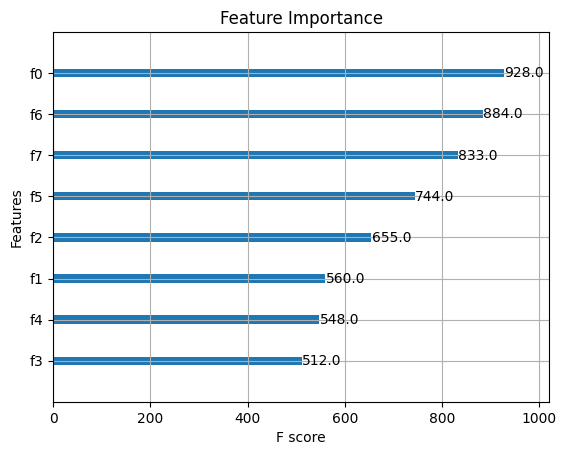

In [12]:
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()


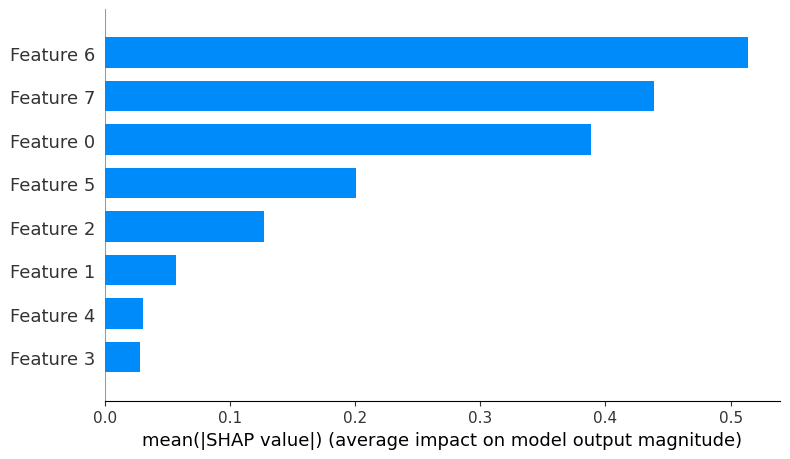

In [13]:
import shap

# Create a SHAP explainer using the XGBoost model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set
# Note: Ensure that the data provided to SHAP values calculation is the same format as used for training (DMatrix in this case)
shap_values = explainer.shap_values(X_test)  # Use your original data here, not DMatrix, if you face issues.

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, plot_type="bar")


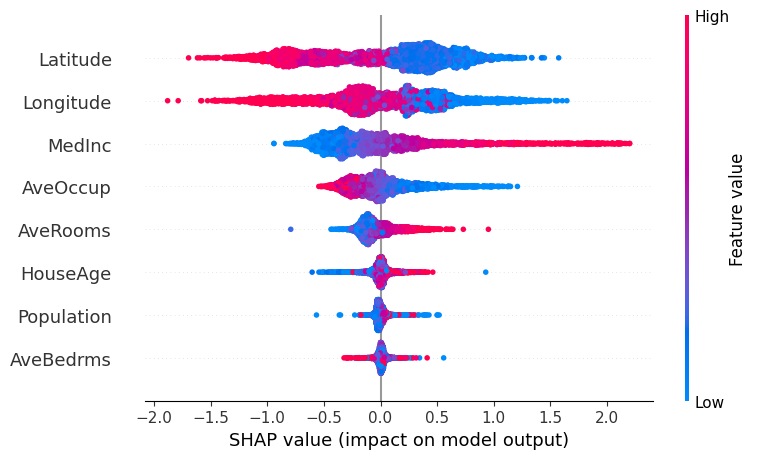

In [14]:
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


In [10]:
# Install necessary libraries
!pip install xgboost shap

# Import necessary libraries
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)
params = {
    'max_depth': 4,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}
model = xgb.train(params, dtrain, num_boost_round=100)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


In [6]:
# Assuming 'data' is your DataFrame
X = data.drop(columns=['docking_score', 'id'])  # drop the target column and the 'id' column
y = data['docking_score']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features for SGDR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ValueError: could not convert string to float: 'CCCC[C@@H]1Oc2ccc(S(=O)(=O)NC(C)C)cc2NC1=O'

In [ ]:
# Assuming 'data' is your DataFrame
X = data.drop(columns=['docking_score', 'id', 'smile'])  # drop the target, 'id', and 'smile' columns
y = data['docking_score']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check if X_train is empty and provide feedback
if X_train.empty:
    print("Error: X_train is an empty DataFrame. Check if you dropped all the columns.")
else:
    # Scaling features for SGDR
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

Error: X_train is an empty DataFrame. Check if you dropped all the columns.
